In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample


✅ Classification Report (Balanced):
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     12.0
1                   1.0     1.0       1.0     14.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     26.0
weighted avg        1.0     1.0       1.0     26.0


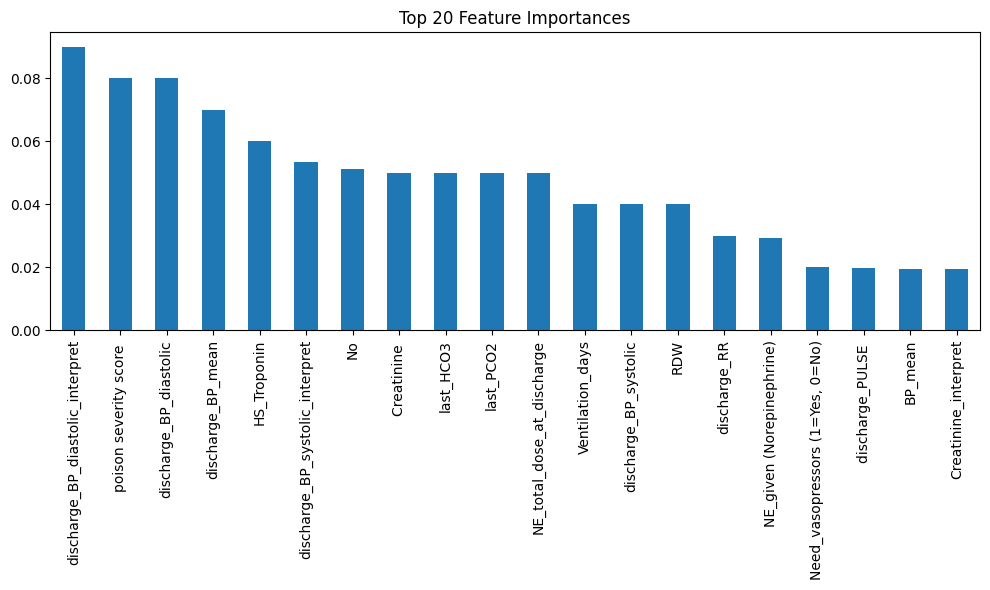

In [2]:

# 📂 1. تحميل الداتا
file_path = "zincphosph1.xlsx"  # عدل المسار لو الملف مش في نفس المجلد

# قراءة كل الشيتات وتجميعهم
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

dfs = [pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_names]
df_full = pd.concat(dfs, axis=1)

# 🧹 2. تجهيز الداتا
target_col = "Survival (1=Survived, 0=Died) "
y = df_full[target_col]
X = df_full.drop(columns=[target_col])

# إزالة الأعمدة المكررة إن وجدت
X = X.loc[:, ~X.columns.duplicated()]

# التعامل مع الـ NA
X = X.fillna(-999)

# 🔄 3. تحويل النصوص لأرقام
X_encoded = X.copy()
for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))

# 🧪 4. عمل Upsampling للفئة الأقل
df_model = X_encoded.copy()
df_model['Survival'] = y.values

df_survived = df_model[df_model['Survival'] == 1]
df_died = df_model[df_model['Survival'] == 0]

df_died_upsampled = resample(
    df_died,
    replace=True,
    n_samples=len(df_survived),  # تساوي عدد الفئة الأكبر
    random_state=42
)

df_balanced = pd.concat([df_survived, df_died_upsampled])

X_balanced = df_balanced.drop(columns=['Survival'])
y_balanced = df_balanced['Survival']

# ✂️ 5. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42
)

# 🌳 6. تدريب الموديل
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 📊 7. تقييم الأداء
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("\n✅ Classification Report (Balanced):")
print(report_df)

# حفظ التقرير لو حبيت
report_df.to_csv("classification_report.csv")

# اختيار أهم الفيتشرز
import matplotlib.pyplot as plt

importances = model.feature_importances_
feat_importance = pd.Series(importances, index=X_balanced.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importance.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()


In [3]:
import pickle

# بعد تدريب الموديل
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)
